
# Transfert d'organe sous incertitude sur la compatibilité

Sibyline Moukarzel, Matthieu Roux

<span style="color:  #FF0000"> **Documentation de base sur les graphes en Julia : https://juliagraphs.org/Graphs.jl/dev/first_steps/access/** </span>

## Introduction

Malgré l'augmentation croissante du nombre de **transplantations d'organes** effectuées chaque année (environ 6000 en 2017 dont 3782 transplantations de reins), la demande reste en perpétuelle augmentation. Ainsi 6000 organes, dont 3782 reins, ont été transplantés en 2017, mais il y avait encore 24000 personnes en attente d'un organe la même année. Les organes transplantés peuvent provenir d'un donneur décédé ou, dans le cas des reins et du foie, d'un **donneur vivant consentant**, le plus souvent membre de la famille du patient. Hélas, même si un proche accepte de prendre ce risque pour sa santé, il ne sera pas forcément compatible avec le patient. Pour cette raison, les pratiques médicales les législations évoluent dans de nombreux pays afin de permettre la mise en place d'un **programme d'échange de dons d'organes**.

L'exemple le plus simple d'échange de don d'organes est celui où deux patients $P_1$ et $P_2$ sont accompagnés de donneurs $D_1$ et $D_2$. Les patients sont supposés incompatibles avec les donneurs qui les accompagnent, mais on suppose que $D_1$ est compatible avec $P_2$ et $D_2$ avec $P_1$. Il est alors possible de transplanter un organe de $D_1$ vers $P_2$ et de $D_2$ vers $P_1$ avec le consentement de tous et en suivant la procédure légale.

Plus généralement, un **cycle d'échange d'organes** associe $k$ paires de patient-donneur $(P_{i_1},D_{i_1}), \dots, (P_{i_k},D_{i_k})$ de sorte que $D_{i_l}$ donne à $P_{i_{l+1}}$ pour $l=1,\dots,k-1$ et $D_{i_k}$ donne à $P_{i_1}$.
Par ailleurs, le point essentiel est que les transferts soient tous réalisés **en même temps et dans le même hôpital** pour éviter qu'une rétractation de dernière minute ne lèse un patient et son donneur, et que les patients et donneurs venus ensemble et leur famille puissent se soutenir émotionnellement durant l'hospitalisation. 
Pour cette raison, le nombre d'échanges prenant place au sein d'un même cycle est nécessairement **limité**. En pratique, l'organisation d'un cycle de trois paires est déjà une épreuve pour le personnel d'un hôpital, et le plus grand cycle ayant jamais eu lieu a a impliqué **six patients et donneurs**.

Dans ce projet, nous prendrons le point de vue de l'**organisme national responsable de la gestion du programme d'échange d'organes**. 
À chaque phase d'échange, l'objectif de cet organisme est de choisir un **ensemble de cycles d'échanges** entre paires compatibles afin de maximiser le nombre de patients recevant un organe. Dans certains cas, on peut aussi donner une priorité à certains patients en fonction de la gravité de leur état ou de la durée de leur attente. 
Pour cela, on pourra attribuer des **poids différents** à chaque patient et maximiser la somme des poids des patients recevant un organe. 

Lors d'une première phase de planification, l'organisme ne dispose que de **données individuelles** sur chaque donneur et chaque receveur pour déduire la compatibilité entre donneurs et patients. 
Ces données sont principalement le groupe sanguin et le complexe majeur d’histocompatibilité, aussi appelé système HLA. 
Ils en tirent un premier **graphe de compatibilité orienté**, $G=(V,A)$, où chaque sommet de $V$ représente une paire donneur-patient et où un arc entre deux paires $(P_k,D_k)$ et $(P_l,D_l)$ signifie que $D_k$ est __a priori__ compatible avec $P_l$.
Cependant, la compatibilité effective entre deux personnes ne peut être assurée qu'en mettant en présence des tissus des deux personnes dans ce que l'on appelle un **_test croisé_**. 
En général, on peut supposer que les données individuelles permettent de déterminer une **probabilité de réussite du test croisé**.
Mais, dans tous les cas, ces tests peuvent être lourds à réaliser pour les patients et demander des ressources importantes auprès des services hospitaliers, donc **leur nombre sera toujours limité**. 
On pourra pour cela considérer une limite fixe, une limite dépendant du nombre de paires patient-donneur ou bien supposer que les tests ne servent qu'à confirmer la compatibilité après avoir décidé les cycles d'échange entre patients a priori compatibles. 

**<span style="color:  #FF0000">Idées de choses à faire :</span>**


    - Tester avec 32 et 64, et 128 (quitte à prendre L = 2) analyser les résultats avec différentes distributions, quels sont les patients soignés (différent du modèle déterministe ?) ? Afficher le temps de calcul ? Regarder si des gens avec un PRA mauvais sont sauvées.
    - Comparer GLPK et HiGHS
    - EVPI et VSS
    - Approche averse aux risques / robuste
    - Restreindre le MPR

## Description des données

Des jeux de données correspondant à des ensembles de paires patient-donneur ont été partagés dans la PrefLib (https://www.preflib.org/data/MD). Le sous-ensemble d'instances auxquels vous pourrez vous intéresser dans un premier temps accompagne ce sujet sur Moodle. Les dix premières instances (numérotées de 1 à 10) contiennent 10 paires patient-donneur, les 10 suivantes (numérotées de 31 à 40) en contiennent 32 et les 10 dernières (numérotées de 71 à 80) en contiennent 64. Chaque jeu de données est décrit par deux fichiers, l'un énumérant les données relatives à chaque paire et portant l'extension .dat, et l'autre énumérant les données relatives aux arcs et portant l'extension .wmd.
Nous vous fournissons une fonction permettant de lire les fichiers relatifs à un jeu de donnéees. 

In [58]:
# include all the necessary packages, if some of them are not installed, you will need to install them before
using Random, MetaGraphs, SimpleWeightedGraphs,JuMP, DelimitedFiles, Distributions, NBInclude, GLPK, GraphPlot, Graphs, Random

In [59]:
# Inclusion du fichier contenant la fonction de parsing des données
@nbinclude("dataparser.ipynb")
# Exemple d'utilisation de la fonction supposant que les fichiers sont dans le dossier data
matthieu_path = "C:/Users/matth/Documents/5GM/optim sous incertitude/stochastic_optimization/data/"
#sibyline_path = "C:/Users/sibyl/Documents/Ecole/INSA - Sciences Po/INSA/5MA/Optimisation sous incertitude/Projet/data/" 

#kep_graph = read_kep_file(sibyline_path*"MD-00001-00000001.wmd", sibyline_path*"MD-00001-00000001.dat");
kep_graph = read_kep_file(matthieu_path*"MD-00001-00000001.wmd", matthieu_path*"MD-00001-00000001.dat");

Une fois le graphe de compatibilité donné, une instance est entièrement décrite par la connaissance de la distribution des incertitudes dans une approche par **optimisation stochastique**. Dans une approche par optimisation robuste, le pire cas est déjà connu pour chaque arête, il s'agit d'un échec de la transplantation. Plusieurs modèles d'incertitudes sont classiquement regardés dans la littérature, mais tous considèrent que la réussite du test croisé réalisé sur un arc $a$ suit une **loi de Bernouilli** de probabilité $1-f_a$ où $f_a$ est une probabilité d'échec donnée. Nous donnons ci-dessous la fonction permettant de calculer des probabilités d'échec pour tous les arcs en fonction d'un paramètre à choisir dans le tableau DISTRIBUTIONS.

In [60]:
global DISTRIBUTIONS = ["Constant","Binomial","BinomialUNOS","BinomialAPD","NoFailure"]

"""
    get_failure_rates

Generate failure rates on each edge, and add its value as a property to the edge of the kep_graph. 

# Parameters
* `kep_graph::MetaDiGraph` : graph describing the pairs and compatibilities
* `distribution::String` : type of distirbution of uncertainties; to be chosen in the DISTRIBUTIONS vector
"""
function get_failure_rates(kep_graph::MetaDiGraph, distribution::String)

    failure_rates = []

    for edge in MetaGraphs.edges(kep_graph)
        # Failure rates depend on the chosen distribution of uncertainties
        if distribution == "Constant"
            # constant failure rates equal to 70%
            set_prop!(kep_graph, edge, :failure, 0.7)
        elseif distribution == "Binomial"
            if rand() < 0.25
                # random failure rates equal to 10% on average for 25% edges
                set_prop!(kep_graph, edge, :failure, rand() * 0.2)
            else
                # random failure rates equal to 90% on average for 75% edges
                set_prop!(kep_graph, edge, :failure, 0.8 + rand() * 0.2)
            end
        elseif distribution == "BinomialUNOS"
            # %pra denotes the panel reactive antibody level
            # %pra of the patient < 0.8 : UNOS low sensitized patients
            if get_prop(kep_graph, edge.dst, :pra) < 0.8
                # failure rate equal to 10% if the patient is low sensitized
                set_prop!(kep_graph, edge, :failure, 0.1)
            else
                # failure rate equal to 90% otherwise 
                set_prop!(kep_graph, edge, :failure, 0.9)
            end
        elseif distribution  == "BinomialAPD"
            # %pra denotes the panel reactive antibody level
            # %pra of the patient < 0.75 : APD low sensitized patients
            if get_prop(kep_graph, edge.dst, :pra) < 0.75
                # failure rate equal to 28% if the patient is low sensitized
                set_prop!(kep_graph, edge, :failure, 0.28)
            else
                # failure rate equal to 58% otherwise 
                set_prop!(kep_graph, edge, :failure, 0.58)
            end
        elseif distribution == "NoFailure"
            # failure rates equal to 0
            set_prop!(kep_graph, edge, :failure, 0.)
        end
    end
end


get_failure_rates

In [61]:
failure_rates = get_failure_rates(kep_graph, "Constant")

In [62]:
print([get_prop(kep_graph,e,:failure) for e in MetaGraphs.edges(kep_graph)])

[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7]

## Travail à réaliser

Nous vous donnons une grande liberté sur la façon de traiter le sujet. En fonction de décisions que vous justifierez, vous pourrez traiter le problème par une approche d'optimisation stochastique, d'optimisation robuste ou de toute autre approche averse aux risques. Le travail commencera par décrire l'approche suivie puis le modèle en découlant. Un code Julia permettra ensuite d'implémenter une ou plusieurs méthodes de résolution pour le modèle. Vous pourrez tester la ou les méthodes sur des instances de la PrefLib. Vos interprétations devront rendre compte des enjeux pratiques et des enjeux algorithmiques (optimalité, temps de calcul, passage à l'échelle, etc.) de votre travail.
Le résultat de votre travail sera à rendre dans ce notebook avant le 14 janvier 2022. Chaque cellule du notebook aura préalablement été exécutée (sans erreur, évidemment), et il importera que les affichages utilisés dans vos interprétations y apparaissent. 

### Réflexion sur le contexte de du projet

Avant de commencer à travailler sur ce projet, il semble important, voire nécessaire de soulever certains **enjeux éthiques**. En effet, le travail effectué ici fait ressortir la place que peuvent avoir les mathématiques dans la résolution de questions médicales, mais aussi la **responsabilité de la modélisation**. Il ne s’agit pas, ici, d’augmenter le profit d’une entreprise, mais d’impacter, de manière directe, sur la **vie de patients** en attente d’une greffe, et dont la survie pourrait ainsi dépendre de la sortie d’un algorithme.
S’il on parle de manière croissante des **méthodes « d’aide à la décision »**, comme peut l’être un modèle mathématique, c’est ici le mot « aide » qui se doit impérativement d’être soulevé. Au-delà d’une simple résolution de problème, les décisions qui peuvent être prises selon les résultats algorithmiques ont un **impact majeur**. Dans le domaine de la santé, il semble ainsi impensable que chacune de ces décisions ne soient pas revues, à minima pour être validées, par un **professionnel médical**. La « double validation » (algorithme & profession de santé) semble bien évidemment nécessaire pour garantir qu’aucune erreur n'est effectuée (oubli de prise en compte d’un paramètre, mauvaise modélisation, non-respect des hypothèses initiales…).
Outre ces questions vitales, il ne faut pas oublier qu’il s’agit ici de **« déshumaniser » un processus de sélection d’individus**. Chaque issue se doit donc d’être pondérée au regard des personnes impliquées, car, comme on le sait, chaque être humain est différent.

Toutefois, la mise en œuvre d’un tel travail n’est pas à blâmer. En effet, c’est également un réel apport pour le corps médical. Il s’agit ici d’avoir l’opportunité de **libérer du temps** pour qu’un médecin le passe avec ses patients plutôt qu’à parcourir des dossiers pour identifier des greffes possibles. En cela, cette **assistance**, puisque l’algorithme n’est qu’une aide, permet un gain de temps qui sera au profit des patients, permettant de leur dédier de l’attention supplémentaire. C’est également un travail qui peut mener à des opportunités introuvables à priori : **au-delà de cycle de taille 2, la détection de compatibilité devient difficile** sans assistance, alors que notre travail le rend facile. C’est donc une possibilité de sauver plus de vie, d’effectuer plus de greffe, et dont la chance de réussite est plus élevée.

Ce discours, probablement critiquable, est indispensable avant un tel projet. Applicable à tous les domaines d’aide à la prise de décision, il n’en est que plus fort lorsqu’il communique étroitement avec la vie des hommes.


### Instance jouet

**Visualisation d'une instance :**

L'instance suivante nous servira d'exemple jouet pour illustrer notre code pas à pas. C'est un graphe nommé `kep_graph` avec 16 couples patients/donneurs.

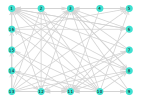

In [63]:
x = [0, 10, 20, 30, 40, 40, 40, 40, 40, 30, 20, 10, 0, 0, 0, 0]
y = [0, 0, 0, 0, 0, 10, 20, 30, 40, 40, 40, 40, 40, 30, 20, 10]
nodelabel = 1:MetaGraphs.nv(kep_graph)
gplot(kep_graph, nodelabel = nodelabel, x, y)

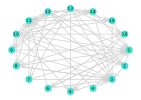

In [64]:
nodelabel = 1:MetaGraphs.nv(kep_graph)
gplot(kep_graph, nodelabel = nodelabel,layout = circular_layout)

## Les probabilités comme données déterministes

Comme première approche, nous considérons que les tests croisés ne servent qu'à **confirmer la compatibilité** d'une paire patient-donneur après avoir déterminé les cycles d'échanges. Le problème est alors **déterministe**.

### Modélisation déterministe sans limite de taille de cycle d'échange
On modélise d'abord notre problème en supposant que **la probabilité d'échange pour chaque arc est de 1** (i.e., pass de test croisé). Autrement dit, à chaque fois qu'un arc existe dans notre graphe, **on sait** que la greffe va réussir. On considère également qu'il n'y a **pas de limite** à la taille des cycles d'échanges.

Notre modèle est le suivant :

On note $p_{i,j}, ~ \forall (i,j) \in A$, les poids des arcs du graphe.

**Variable :**  
- $x_{i,j} \in \{1,0\}$, $x_{i,j} = 1$  si le donneur de la paire i donne au patient de la paire j 


**Objectif :**

- maximiser le nombre d'échange : max $\sum_{i,j : (i,j) \in A} x_{ij} p_{ij}$   

**Contraintes :**

- $\sum_{j : (j,i) \in A} x_{ji} = \sum_{j : (i,j) \in A} x_{ij}$, $\forall i \in V$, (le patient i recoit un rein ssi le donneur i donne un rein)

- $\sum_{j : (i,j) \in A} x_{ij} \le 1$, $\forall i \in V$, (un donneur peut donner seulement un rein) 

In [65]:
"""
Edges_MIP 

Inputs : 
    - kep_graph : le graphe que l'on souhaite optimiser

Outputs :
    - valeure de notre fonction objectif à l'optimum
    - vecteur solution de l'optimim

"""
function edges_MIP(kep_graph::MetaDiGraph)
    nb_vertices = MetaGraphs.nv(kep_graph)
    #modele = Model(Gurobi.Optimizer)
    modele = Model(GLPK.Optimizer)
    
    # Nombre de paires de donneurs/patients, nombre de noeuds du graphe :
    P = MetaGraphs.nv(kep_graph)
    #N
    compatible = [(i,j) for i in 1:nb_vertices, j in 1:nb_vertices if MetaGraphs.has_edge(kep_graph, i,j)]

   
    # Variable : indique si le patient de la paire j a un rein du donneur de la paire i
    @variable(modele,x[i in 1:P,j in 1:P],Bin)
    
    # Contrainte : le patient i recoit un rein ssi le donneur i donne un rein
    @constraint(modele,recoit[i in 1:P],sum(x[j,i] for j in 1:P if ((j,i) in compatible)) == sum(x[i,j] for j in 1:P if ((i,j) in compatible)))
    # Contrainte : un donneur peut donner seulement un rein
    @constraint(modele,capacite[i in 1:P],sum(x[i,j] for j in 1:P if ((i,j) in compatible))<=1)

    # Contrainte : on veut des cycles plus petits que L
    
    # Objectif : maximiser le nombre total de transplantations
    @objective(modele,Max,sum(x[i,j]*(1 - get_prop(kep_graph,Graphs.SimpleGraphs.SimpleEdge(i, j),:failure)) for (i,j) in compatible))
 
    set_optimizer_attribute(modele, MOI.Silent(), true)
    optimize!(modele)

return JuMP.objective_value(modele), JuMP.value.(x)
end

edges_MIP

Pour la réussite de cette méthode, **une seule condition est nécessaire** : qu'il existe au moins un cycle dans notre graphe.

Le code suivante `plot optimized_edges` permet de représenter visuellement la solution optimale obtenues précédemment.

In [66]:
function plot_optimized_edges(kep_graph::MetaDiGraph,xsol)
    #plot_x = [0, 10, 20, 30, 40, 40, 40, 40, 40, 30, 20, 10, 0, 0, 0, 0]
    #plot_y = [0, 0, 0, 0, 0, 10, 20, 30, 40, 40, 40, 40, 40, 30, 20, 10]
    nb_vertices = MetaGraphs.nv(kep_graph)
    nodelabel = 1:nb_vertices
    optimized_graph = MetaDiGraph(nb_vertices, 0)

    for i in 1:nb_vertices
        for j in 1:nb_vertices
            if xsol[i,j]>0
                MetaGraphs.add_edge!(optimized_graph, i, j, :weight, xsol[i,j])
            end 
        end
    end
    gplot(optimized_graph, nodelabel = nodelabel, layout = circular_layout)
end


plot_optimized_edges (generic function with 1 method)

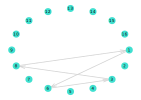

In [47]:
failure_rates = get_failure_rates(kep_graph, "Constant")
obj1, x1 = edges_MIP(kep_graph)
plot_optimized_edges(kep_graph, x1)

On va donc ici que la **solution optimale** proposée est un cycle impliquant quatre paires : 1-6-3-8-1. On a donc quatre individus sauvés. On peut également en déduire que c'est **le plus long cycle** du graphe, puisqu'aucune limite de taille n'est appliquée.

### Optimisation "selon les cycles"

La modélisation précédente ne permet pas de modéliser la **taille limite de cycle d'échange**. On décide donc de faire une modélisation qui cherche à maximiser le nombre de cycle d'échange.

Cette modélisation s'appuie sur le constat suivant : si on connait la probabilité de réussite d'une greffe (c'est-à-dire, de son test croisé), on connait la **probabilité de réussite d'un cycle**. On note $p_{ij}$ la probabilité de réussite d'une greffe entre le donneur $D_i$ et le patient $P_j$. Ce constat s'appuie sur l'hypothèse que toutes les greffes ont la **même chance de réussite** durant l'opération (pas d'erreur de manipulation du médecin pratiquant la greffe).

Par ailleurs, on peut raisonnablement supposer que **les probabilité de réussite des greffes d'un cycle sont indépendantes**, puisque les donneurs/patients sont tous différents. On suppose par ailleurs qu'il n'y a **pas d'erreur médicale**, et que, une probabilité $p_{ij} = 1$ sera forcément une **greffe réussie**. Dans ce cas, la probabilité de réussite d'un cycle $c = (1, 2, ..., k)$ est données par $p_c = \prod\limits_{i = 1}^{k-1} p_{i, i+1}$, autrement dit, **le produit des probabilités du cycle**. 

Pour réaliser cette modélisation, il est nécessaire de **lister les cycles** du graphes de longueur inférieur ou égale à L. Dans la réalité, on ne s'intéressera jamais aux grands cycles puisqu'on ne fait pas beaucoup de greffes en simultané. Le plus grand cycle historiquement réalisé est de 6 greffes mais dans les faits, **on réalise rarement plus de 3 greffes simultanément** pour des questions de faisabilité médicale.

#### Trouver les cycles du graphe
La fonction `liste_cycles` liste l'ensemble des cycles du graphe `G` de taille inférieure ou égale à `L`. Avec cette fonction, pour trouver tous les cycles d'un graphe, il suffit que mettre L égal au nombre de sommets.

Par exemple, le graphe `kep_graph` contient 3 cycles de taille inférieure à 4, que l'on peut retrouver ci-dessous.

In [48]:
"""
ENTREES :
    # G : graphe avec les pairs patients/donneurs
    # L : taille maximal d'un cycle
    
SORTIES :
    # cycles : ensemble des cycles dans le graphe de longueur inférieure à L
"""
function liste_cycles(G::MetaDiGraph, L::Integer)
    paires = [i for i in 1:nv(G)]
    cycles = []
    
    function enumeration(p, c, L)
        for s in neighbors(G, p) #  Successeurs de p
            if s == c[1] # Si c'est le premier sommet du cycle
                append!(cycles, [c])
            elseif s < c[1]
                continue
            elseif s in c
                continue
            elseif length(c) <= L-1
                c_copie = copy(c)
                append!(c_copie, s)
                enumeration(s, c_copie, L)
            end
        end 
    end
    
    for p in paires
       c = [p]
        enumeration(p, copy(c), L)
    end
    
return(cycles)
end

liste_cycles

In [49]:
liste_cycles(kep_graph, 4)

3-element Vector{Any}:
 [1, 6]
 [1, 6, 3, 8]
 [3, 8]

La fonction `plot_cycle_edges` permet d'afficher graphiquement les cycles identifiées dans le graphe.

In [50]:
function plot_cycle_edges(kep_graph, cycles)
    nb_vertices = MetaGraphs.nv(kep_graph)
    nodelabel = 1:nb_vertices
    graph_to_plot = MetaDiGraph(nb_vertices, 0)
    for li in cycles
        for i in 1:(length(li)-1)
            MetaGraphs.add_edge!(graph_to_plot, li[i], li[i+1], :weight, 1)
        end
        MetaGraphs.add_edge!(graph_to_plot, li[length(li)], li[1], :weight, 1)
    end
    gplot(graph_to_plot, nodelabel = nodelabel, layout = circular_layout)
end

plot_cycle_edges (generic function with 1 method)

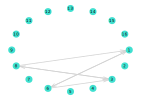

In [51]:
plot_cycle_edges(kep_graph, liste_cycles(kep_graph, 4))

En fixant la taille maximale du cycle à 2, on peut voir qu'il nous reste plus que 2 cycles :

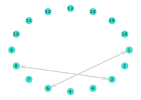

In [52]:
plot_cycle_edges(kep_graph, liste_cycles(kep_graph, 2))

#### Modélisation mathématique

On cherche maintenant à utiliser les cycles et leur poids (définié précédemment), pour modéliser notre problème.

Le modèle s'écrit comme suit :

Soit $C(L)$ l'ensemble des cycles du graphe de longueur au plus $L$. Soit $V$ l'ensemble des sommets (paires patients/donneurs) du graphes.
Soit $p_c$ la probabilité de réussite associée au cycle $c$, pour tout $c \in C(L)$. On peut décider de prendre en compte ou non la longueur des cycles. 


**Variables :**

* $z_c$ : vaut 1 si le cycle $c$ est choisi, 0 sinon, pour tout $c \in C(L)$

**Objectif :** On veut maximiser le nombre de cycle en tenant compte de leur probabilité de réussite  
$$max \sum \limits_{c \in C(L)} p_c z_c$$

**Contraintes :**
* Un sommet appartient au plus à 1 cycle: $\forall i \in I, \sum \limits_{c:i \in V(c)} z_{c} \le 1$

* Binarité et positivité des variables : $\forall c \in C(L) z_c \in \{0, 1\}$

Ce modèle est codé par la fonction `determinist_weighted_cycle_MIP`. Celui-ci est complété par une fonction `proba_cycle` qui permet de calculer la probabilité de réussite d'un cycle en faisant les produits des probabilité des arcs qui le compose.

Cette modélidation permet de **pénaliser les longs cycles**. En effet, un long cycle de longueur 4 aura sans doute une **probabilité plus faible de réussite** qu'un cycle de longueur 2 puisque le cycle de longueur 4 implique plus de greffes (produit de probablités inférieures à 1).

Par ailleurs, si on se place dans un cas où toute les greffes ont une probabilité de réussite égale à 1, tous les cycles ont une probabilité de 1. Dans ce cas, on maximise le **nombre de cycles** sans considération de sa taille.

Si on souhaite prendre en compte la tailles des cycles dans la modélisation, on peut décider de rajouter un poids $l_c$ - qui corespond à la taille d'un cycle c - devant chaque cycle $l_c$.



In [53]:
function proba_cycle(G, c)  
    proba = 1
    n = size(c)[1]
    for i in 1:(n-1)
        proba = proba*(1 - get_prop(G,Graphs.SimpleGraphs.SimpleEdge(c[i], c[i+1]),:failure))
    end
    proba = proba *(1- get_prop(G,Graphs.SimpleGraphs.SimpleEdge(c[n], c[1]),:failure))
    return proba
end    

proba_cycle (generic function with 1 method)

In [54]:
function determinist_weighted_cycle_MIP(kep_graph::MetaDiGraph, cycles, take_length = true)
    nb_vertices = MetaGraphs.nv(kep_graph)
    # modele = Model(Gurobi.Optimizer)
    modele = Model(GLPK.Optimizer)
    
    # On récupère les probabilités de réussite de chaque cycle
    succes = []
    for c in cycles
       append!(succes, proba_cycle(kep_graph, c)) 
    end
    lc = ones(length(cycles))
    if take_length == true
        lc = [length(c) for c in cycles]
    end

    # Variable : indique si le cycle c est sélectionné ou non
    @variable(modele, z[c in 1:length(cycles)], Bin)
    
    # Contrainte : une paire patient/donneur ne peut s'impliquer que dans un cycle au maximum
    @constraint(modele, max_cycle[i in 1:nv(kep_graph)], sum(z[c] for c in 1:length(cycles) if i in cycles[c]) <= 1)
    
    # Objectif : maximiser le nombre total de cycles ou de transplantations
    @objective(modele, Max, sum(succes[c]*z[c]*lc[c] for c in 1:length(cycles)))
    set_optimizer_attribute(modele, MOI.Silent(), true)
    optimize!(modele)
    
    sol = []
    for i in 1:length(cycles)
        if  JuMP.value.(z)[i] == 1.0
            push!(sol, cycles[i])
        end
    end
    save_chance = 0
    if take_length == false
        lc = [length(c) for c in cycles]
        save_chance = sum(JuMP.value.(z)[i]*lc[i]*succes[i] for i in 1:length(cycles))
    else
        save_chance = JuMP.objective_value(modele)
    end
return sol, save_chance
end

determinist_weighted_cycle_MIP (generic function with 2 methods)

En fixant $L=4$, on sait que 3 cycles existent dans notre graphe : 1-6-1, 3-8-3, et 1-6-3-8-1. Comme attendu, notre méthode va choisir **les deux plus petits cycles** (qui permettent de sauver les mêmes individus que le grand cycles), puisque la probabilité des cycles sont plus petites.

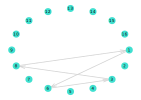

In [55]:
failure_rates = get_failure_rates(kep_graph, "NoFailure")
cycles = liste_cycles(kep_graph,4)
sol,save = determinist_weighted_cycle_MIP(kep_graph, cycles, true)
plot_cycle_edges(kep_graph, sol)

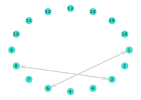

In [57]:
sol,save = determinist_weighted_cycle_MIP(kep_graph, cycles, false)
plot_cycle_edges(kep_graph, sol)

### Optimisation averse au risque (in progress)

Nous voulons **sauver le maximum de personnes** et chaque donnation doit être validée au préalable par un test croisé.

Il semble naturel de vouloir éviter de faire des **tests non concluants**. En effet, un test non concluant peut donner de faux espoirs à une personne et entraîne un surcoût.

On peut donc rajouter la contrainte suivante à notre modèle : $\mathbb{P} (z^k_c \text{ successful}) \geq \alpha$: on veut que la probabilité de réussite du cycle $c$ du scénario $k$ doit être supérieur à un certain $\alpha$.

Cette perspective peut être intéressante si on ne prend pas en compte **taux d'anticorps réactif de panel (PRA)**. Un anticorps réactif de panel est créé lorsqu'un tissu étranger est introduit dans le corps. Si ce taux d'anticorps est élevé pour un receveur, il sera beaucoup plus difficile de lui faire corespondre un organe donneur (source : https://spiegato.com/fr/quest-ce-quun-anticorps-reactif-de-panel)   

Ainsi, les patients avec un fort PRA ont une probabilité de réussite de greffe **plus faible**, les cycles contenant ces personnes ont donc  également une probabilité plus faible de réussite. Par conséquent, avec cette **contrainte en probabilité**, ces patients à fort PRA ont très peu de chance de se retrouver dans un cycle d'échange et sont donc pénalisés.   


**<span style="color:  #FF0000">Rajouter une contrainte en probabilité pour sauver les personnes les plus en détresse.</span>**


## Le choix des tests croisés s'effectue avant le choix du cycle

On suppose maintenant que l'on a un **nombre de tests croisés limités** et que l'on doit **choisir quels sont les tests croisés à faire** avant la réslisations des incertitudes. Pour cela, on établie un modèle d'**optimisation stochastique** sous forme de problème avec recours. Son fonctionnement se base sur une étude par arc : on va identifier les arcs impliqués dans des cycles d'échanges présents dans notre graphe $G$.

Le modèles s'écrit comme suit

__Données déterministes :__
- $L$ : longueur maximale des cycles considérés
- $G$ : graphe étudié
- $A$ : ensemble des arcs impliqués dans un ou plusieurs cycles de longueur maximale $L$, avec $|A| = n$
- $S$ : ensemble des sommets impliqués dans un ou plusieurs cycles de longueur maximale $L$
- $C$ : ensemble des cycles de longueur maximale $L$ dans le graphe $G$
- $l_c$ : longueur du cycle $c$, pour tout cycle $c \in C$
- $I(s)$ : ensemble des cycles de longueur maximale $L$ dans lesquels est impliqué le sommet $s$, pour tout $s \in S$ 


__Données stochastiques :__
- $\xi^k \in \{0,1\}^n$ : vecteur stochastique où chaque $\xi_a^k, a\in \{1,...,n\}$ indique si le test croisé a été réussi (1) ou si son résultat est negatif (0) dans le scénario $k \in \{1,...,K\}$. Chaque $\xi^k_a$ est tiré aléatoirement selon une loi de Bernoulli de paramètre $1-p_a$ avec $a\in A$ où $p_a$ est la probabilité d'échec du test croisé porté par l'arc $a$ dans le graphe $G$. Il s'agit donc de notre donnée aléatoire.
- $p_k$ : probabilité associée au scénario $\xi_k$, pour tout $k \in \{1, ..., K \}$

__Variables__ :

1er ordre :

- $ \forall a \in A \ \eta_a = 
    \begin{cases} 
    1 \text{ si le test entre (i,j) = a est effectué} \\
    0 \text{ sinon}
   \end{cases}$

    
Recours :

- $\forall c \in C, k \in \{1, \dots, K\} z^k_c = 
    \begin{cases} 
    1 \text{ si on choisit le cycle c dans le scénario k} \\
    0 \text{ sinon}
   \end{cases}$



__Objectif__ : maxmimiser le nombre de personnes sauvées 

$$ max_{z^k_c} \mathbb{E}[ \underset{c}{\Sigma} l_c z^k_c ] = \underset{k}{\Sigma} p_k \ \underset{c}{\Sigma} l_c z^k_c  $$



__Contraintes__ : 

- Une personne ne peut donner qu'un seul rein (un sommet appartient au plus à un cycle choisi) :  $\forall s \in S, \forall k \in \{1,...,K\}, \sum \limits_{c \in I(s)} z^k_{c} \le 1 ~~~~ (1)$

- Tous les tests croisés des arcs d'un cycle doivent avoir été effectués avant que le cycle ne soit choisi : $\forall c \in C, \ \forall a \in c \ \forall k \in \{1,...,K\},  z^k_c \le \eta_a ~~~~ (2) \ \  $

- Un cycle ne peut être choisi que si l'ensemble des tests croisés de ses arcs sont positifs : $\forall c \in C, \ \forall a \in c, \ \forall k \in \{1,...,\}, z^k_c \le \xi^k_a ~~~~ (3) \ \  $

- On ne peut faire qu'un certain nombre de tests : $\underset{a\in A}{\Sigma}\eta_a = M ~~~~ (4)$

- Positivité et binarité des variables : $\forall a \in A, \eta_a \in \{0,1\}$ et $\forall c \in C, \forall k \in \{1,...,K\}, z^k_c \in \{0,1\} ~~~~ (5) $
  
__Remarque :__
Dans cette formulation, nous avons $2^n$ scénarios possibles (puisque $\xi^k \in {0,1}^n, \forall k\in \{1,...,K\}$). Dans le cas où l'ensemble $A$ est de grande dimensions (i.e., $|A| = n$ est grand), on va donc s'appuyer sur la Loi Forte des Grands Nombres pour utiliser une **méthode Monte-Carlo**. Nous allons alors faire un tirage de scénarios (donc un tirage de vecteurs $\xi^k$) : il y aura $K$ tirages.

### Résolution du problème

Comme notre problème peut vite contenir un **très grand nombre de variables ($n + |C|\times K$) binaires** lorsque le nombre de cycles et/ou le nombre de scénarios augmente(nt), le modèle mathématique peut rapidement devenir **long et difficile à résoudre**. En effet, il est possible de le fournir à un solveur et d'attendre un résultat, mais ce sera **sans assurance du temps d'exécution**. Pour limiter ce risque, on peut donc se tourner vers un algorithme basé sur la **méthode en L (*L-shaped algorithm*)** fonctionnant par l'ajout de coupe d'optimalité. Toutefois, même si de prime abord cette solution parait pratique, elle n'en reste pas moins coûteuse en travaillant sur des **variables binaires** en grand nombre.  

Pour éviter cela, c'est donc sur une **relaxation** que nous allons essntiellement nous appyer. En effet, nous allons **relâcher la contrainte d'intégrité sur notre variable de recours**, pour limiter la contrainte à : $\forall c \in C, \forall k \in \{1,...,K\}, 0 \le z_c^k \le 1$. De cette manière, la méthode en L sera bien plus rapide.

Pour effectuer selon, nous allons donc nous appuyer sur la **décomposition de Benders**, pour obtenir un problème maître (MPR) et $K$ sous-problèmes (un par scénario) comme il suit.

__Problème maître initial :__ $(\mathbb{MPR}):\max \{0: \underset{a\in A}{\Sigma}\eta_a \leq M\}$


__Sous-problèmes :__  $\begin{equation*}
Q(\eta,\xi^k) =  \begin{cases}
	\max \ \sum\limits_{c \in C} l_c z^k_c \\
	\sum \limits_{c \in I(s)} z^k_{c} \le 1 \  \forall s \in S, \\
	\xi^k_a \geq z^k_c \ \ \ \forall c \in C, \ \forall a \in c  \\
	 \eta_a \geq z^k_c \ \ \ \forall c \in C, \ \forall a \in c\\
	 z^k_c \in \{0,1\}, ~ \forall c \in C
	 \end{cases}
\end{equation*}$ $~~~~$ pour tout $k \in \{1,...,K\}$  

On peut alors relâcher la contrainte d'intégrité (dernière contrainte) pour appliquer la méthode en L.

On note qu’ici il n’est pas utile de faire appel à la méthode L-shaped sur le problème non relâché. En effet, la méthode en L, si elle converge, ce qui est toujours le cas ici, convergera vers une **solution entière**, qui est toujours **optimale** pour le problème entier. Par ailleurs, l’utilisation d’un solveur semble simplement inutile puisqu’il est évident que ses performances seront plus mauvaises, le tirage de K scénarios augmentant considérablement la taille du problème.

### Pré-traitement

On décompose le problème en différentes étapes pour faciliter sa résolution. On commence notamment par un **pré-traitement** du graphe considéré pour obtenir différents ensembles dont nous auront besoin.

On crée donc un algorithme de pré-traitement dont le but est d'identifier différents ensembles de sommets/arcs/cycles dans le graphe :
* `cycles` : ensemble des cycles dans le graphe
* `lc` : vecteur donnant la longueur de chaque cycle (nombre de sommets du cycle)
* `Ac` : ensemble des arcs impliqués dans chaque cycle
* `A`: ensemble des arcs impliqués dans un ou plusieurs cycles de notre graphe
* `I` : ensemble des cycles dans lesquels sont impliqués les sommets (le sommet est donc à donner en indice de `I`)
* `Ca` : ensemble des cycles dans lesquels sont impliqués les arcs (l'arc est donc à donner en indice de `Ca`)

In [20]:
"""
ENTREES :
    # graph : graphe avec les pairs patients/donneurs
    # L : taille maximal d'un cycle
    
SORTIES :
    # cycles : ensemble des cycles dans le graphe de longueur inférieure à L
    # lc : longueur de chaque cycle
    # Ac : ensemble des arcs par les cycles
    # A : ensemble des arcs impliqués dans un ou plusieurs cycles de longueur inférieure à L
    # I : ensembles des indices des cycles dans lesquels sont impliqués les sommets S (dict : sommet => [indices])
    # Ca : ensemble des cycles par arc
"""
function pre_traitement(graph, L)
    
    cycles = liste_cycles(graph, L)
    lc = [] 
    Ac = []
    A = []
    I = Dict()
    
    nbc = length(cycles)
    
    for i in 1:nbc
        
        c = cycles[i]
        Acc = []
        
        append!(lc, length(c))
        
        for s in 1:(length(c)-1) # On parcourt les sommets du cycles
            arc = [c[s], c[s+1]]
            append!(Acc, [arc])
            if (arc in A) == false
                append!(A, [arc])
            end
            if (c[s] in keys(I)) == false # Ajouter le sommet à la liste s'il n'y est pas déjà
                I[c[s]] = []
                for k in 1:length(cycles) # On cherche les autres cycles dans lesquels il apparait
                    if (c[s] in cycles[k]) == true
                        append!(I[c[s]], k)
                    end
                end
            end
                        
        end
        
        # On refait la même chose pour le dernier élément du cycle
        arc = [c[length(c)], c[1]]
        append!(Acc, [arc])
        if (arc in A) == false
            append!(A, [arc])
        end
        if (c[length(c)] in keys(I)) == false
            I[c[length(c)]] = []
            for k in 1:length(cycles)
                if (c[length(c)] in cycles[k]) == true
                    append!(I[c[length(c)]], k)
                end
            end
        end
        
        append!(Ac, [Acc])
        
    end
    
        # On cherche dans quel cycle se trouve chaque arc
        Ca = Dict()
        for a in A 
            Ca[a] = []
            for i in 1:length(cycles)
                if (a in Ac[i]) == true
                    append!(Ca[a], i)
                end
            end
        end
   
    
    return cycles, lc, Ac, A, I, Ca
end

pre_traitement

Pour avoir un aperçu des résultats du pré-traitement, on crée une fonction complémentaire `description_cycles` qui permet d'afficher les cycles et leurs caractéristiques. Cette fonction est notamment utile pour des graphes avec peu de cycles.

In [21]:
function description_cycles(graph, L)
    cycles, lc, Ac, A, I, Ca = pre_traitement(graph, L)

    println("====================================")
    println("LISTE ET CARACTERISTIQUES DES CYCLES")
    println("====================================")

    for i in 1:length(cycles)
        println("\n")
        println("Le cycle ", cycles[i], " est de longueur ", lc[i])
        println("  Il est constitué des arcs ", A[i])
        println("  Et ses sommets sont :")
        for j in 1:length(cycles[i])
            println("\t - ", cycles[i][j], ", présent que l'on retrouve dans les cycles ", I[cycles[i][j]])
        end
    end
    println("\n")
    println("====================================")
end

description_cycles (generic function with 1 method)

In [22]:
description_cycles(kep_graph, 6)

LISTE ET CARACTERISTIQUES DES CYCLES


Le cycle [1, 6] est de longueur 2
  Il est constitué des arcs [1, 6]
  Et ses sommets sont :
	 - 1, présent que l'on retrouve dans les cycles Any[1, 2]
	 - 6, présent que l'on retrouve dans les cycles Any[1, 2]


Le cycle [1, 6, 3, 8] est de longueur 4
  Il est constitué des arcs [6, 1]
  Et ses sommets sont :
	 - 1, présent que l'on retrouve dans les cycles Any[1, 2]
	 - 6, présent que l'on retrouve dans les cycles Any[1, 2]
	 - 3, présent que l'on retrouve dans les cycles Any[2, 3]
	 - 8, présent que l'on retrouve dans les cycles Any[2, 3]


Le cycle [3, 8] est de longueur 2
  Il est constitué des arcs [6, 3]
  Et ses sommets sont :
	 - 3, présent que l'on retrouve dans les cycles Any[2, 3]
	 - 8, présent que l'on retrouve dans les cycles Any[2, 3]




### Approche Monte-Carlo

**<span style="color:  #FF0000">Lire la section du poly sur le sujet.</span>**

Comme énoncé précédemment, le vecteur $\xi^k \in \{0,1\}^n, k\in \{1,...,K\}$ décrit la **réussite des tests croisés** des arcs impliqués dans des cycles. On rappelle également que chaque $\xi_a^k$ suit une **loi de Bernoulli** de paramètre $1-p_a$ où $p_a$ réprésente la probabilité d'échec du test croisé de l'arc $a$ (indiqué sur le graphe), pour tout $a \in A$ ; les $\xi_a^k$ sont **indépendants**, pour tous les scénarios $k$.  

Le nombre de vecteur $\xi^k$ possibles (ce qui revient au nombre de scénarios différents) augmente donc **exponentiellement** avec le nombre d'arcs impliqués dans un cycle, puisqu'il y a $2^n$ combinaisons tirages différents ($n = |A|$). Lorsque $n = 10$, on a donc 1024 vecteurs $\xi^k$ possibles (même s'ils n'ont pas forcément tous la même probabilité d'être tirés), mais lorsque $n = 20$, on dépasse le million de combinaisons. On comprend donc facilement que sur des grands modèles, il devient difficile, voire impossible, de prendre en compte chaque vecteur $\xi^k$ possible.  

Dans ce cas là, on se tourne vers une **approche Monte-Carlo**. On va donc tirer $K$ vecteurs $\xi^k \in \{0,1\}^n$, avec $ \in \{1,...,K\}$ avec remise (on peut donc tirer plusieurs fois le même vecteur). La probabilité d'obtenir chacun des vecteurs tirés (= scénarios) est donc de $\frac{1}{K}$.  

Pour cela, on crée donc la fonction `proba_test` qui permet de **tirer un vecteur $\xi$ aléatoirement** (avvec remise), selon les probabilités indiquées sur les arcs du graphe dans des cycles de longueur inférieure à $L$. En sortie, on obtient donc un vecteur binaire où un **1 représente un test réussi et 0 un test échoué**. C'est notre **donnée stochastique**.

In [23]:
function proba_test(graph, L, cycles, lc, Ac, A, I, Ca)
    
    n = length(A)
    
    xi = zeros(n) # vecteur de REUSSITE des tests croisés (loi de Bernoulli)
    
    for i in 1:n
        p_succes = 1 - get_prop(graph, Graphs.SimpleGraphs.SimpleEdge(A[i][1], A[i][2]),:failure)
        distrib = Bernoulli(p_succes)
        xi[i] = Int(rand(Bernoulli(p_succes), 1)[1])
    end
    
    return xi
end   

proba_test (generic function with 1 method)

### Méthode en L (avec relaxation)

Avec le travail préalablement fait, on peut désormais passer au codage de la **méthode en L**. Pour aller l'algorithme, on choisit de faire une fonction spécifique aux sous-problèmes, qui ne rend que les valeurs recherchées pour la résolution. Le problème maître, quant à lui, est **directement intégré à notre algorithme** de la méthode en L. On travaille ici sur la version **relâchée**.

Dans cette méthode `relax_sub`, on fournit en paramètres le graphe étudie, ainsi que les sorties du pré-traitement, accompagnés de notre vecteur $\xi^k$ du scénario $k$ considéré ainsi que notre variable de premier niveau $\eta$.  
Le sous-problème est alors défini en fonction des données d'entrée, et est résolu sur le paramètre `dual` a la valeur `true` (`verbose` correspond simplement à l'affichage des différentes étapes du code). Son fonctionnement se déroule en deux étapes :  
1 - Définition du problème : variable, contraintes et objectif  
2 - Si `dual = true`, le problème est résolu et sont rendues en sortie les valeurs des variables duales (après vérification de leur existence) sous forme de dictionnaires, ainsi que celles de l'objectif et de la variable $z_c^k$  

Il s'agit bien ici de la **relaxation de la contrainte d'intégrité des variables du sous-problème**, donc $z_c^k \in [0,1], ~ \forall c \in C, ~ \forall k \in \{1,...,K\}$.

In [24]:
"""
Sous-problème relâché associé au scénario k, pour une donnée stochastique xi

ENTREES :
    graph : graphe avec les pairs patients/donneurs
    cycles : ensemble des cycles dans le graphe
    lc : longueur de chaque cycle
    Ac : ensemble des arcs dans chaque cycle
    A : ensemble des arcs dans un ou plusieurs cycles
    I : ensembles des indices des cycles dans lesquels sont impliqués les sommets de S
    xi : vecteur aléatoire (supposé i.i.d.) donnant les tests réussis
    eta : vecteur donnant les tests effectués (cf. MRP)
    dual : résoudre le problème et rendre les duaux (false par défaut)
    verbose : afficher la formulation mathématique du problème (false par défaut)
    solveur : indique le solveur à utiliser pour la résolution du problème
    
SORTIES : sous-problème associé au scénario k
"""
function relaxed_sub(graph, cycles, lc, Ac, A, I, xi, eta, dual = false, verbose = false, solveur = "GLPK")
    
        if solveur == "GLPK"
        modele = Model(GLPK.Optimizer)
    else
        modele = Model(HiGHS.Optimizer)
    end
    
    # Variable : tous les cycles pouvant être choisis
    nbc = length(cycles)
    @variable(modele, 0 <= z[c in 1:nbc] <= 1)
    
    # Contrainte : Un donneur ne peut donner qu'un rein
    @constraint(modele, unique_don[s in keys(I)], sum(z[c] for c in I[s]) <= 1)
    
    # Contrainte : Tous les tests croisés du cycles doivent être valides pour que le cycle puisse être choisi
    # [findall(x->x==a, A)[1] for a in Ac[c]] : liste des positions des arcs de Ac[c] dans xi
    @constraint(modele, test_valide[c in 1:nbc, i in [findall(x->x==a, A)[1] for a in Ac[c]]],  z[c] <= xi[i])
    
    # Contrainte : Tous les tests croisés du cycles doivent avoir été effectué pour que le cycle puisse être choisi
    # # [findall(x->x==a, A)[1] for a in Ac[c]] : liste des positions dans eta des arcs de Ac[c]
    @constraint(modele, test_effectue[c in 1:nbc, i in [findall(x->x==a, A)[1] for a in Ac[c]]],  z[c] <= eta[i])
    
    # Objectif : maximiser le nombre total de transplantations
    @objective(modele, Max, sum(z[c]*lc[c] for c in 1:nbc))
    
    if verbose == true
        println(modele)
    end
    
    if dual == true
        set_optimizer_attribute(modele, MOI.Silent(), true)
        optimize!(modele)
        if verbose == true
            println(JuMP.value.(z), JuMP.objective_value(modele))
        end
        
        if JuMP.has_duals(modele) == true
            
            don = Dict()
            for s in keys(I)   don[s] = -JuMP.dual(unique_don[s])    end
            
            valide = Dict()
            for c in 1:nbc
                valide[c] = Dict()
                for i in [findall(x->x==a, A)[1] for a in Ac[c]]
                    valide[c][i] = -JuMP.dual(test_valide[c,i])
                end   
            end
            
            effectue = Dict()
            for c in 1:nbc
                effectue[c] = Dict()
                for i in [findall(x->x==a, A)[1] for a in Ac[c]]
                    effectue[c][i] = -JuMP.dual(test_effectue[c,i])
                end   
            end
            return don, valide, effectue, JuMP.objective_value(modele), JuMP.value.(z)
        end
        println("Pas de duaux")
        
    end

    return modele
end

relaxed_sub

On peut ensuite créer la **méthode en L pour le sous-problème relâché**. Elle prend en entrée tous les éléments nécessaires à la résolution :
- `graph` : le graphe que l'on étudie
- `L`: la longueur maximale des cycles de greffe que l'on souhaite faire
- `M` : le nombre de tests croisés que l'on peut faire
- `nb_sce` : le nombre de scénarios que l'on veut prendre en compte (i.e., nombre de tirages indépendants par la méthode Monte-Carlo)
- `verbose` : l'affichage (ou non) des différents étapes des itérations
- `itmax` : le nombre maximal d'itérations que l'on s'autorise à faire (en cas de non-convergence ou en cas de convergence "lente")
- `solveur` : indique si on utilise GLKP ou HiGHS pour la résolution des problèmes
- `tol` : un critère de tolérance pour l'arrêt dans le calcul de la fonction objectif

Dans cette méthode, la première itération est effectuée à la main, avant d'entrer dans une boucle `while`. Cette première itération consiste à : 
* définir le problème maître inital (variable, contraintes et objectif)
* résoudre ce problème maître initial
* tirer les différents $\xi^k$ pour le nombre de scénarios choisi
* récupérer les valeurs duales des sous-problèmes après résolution par la méthode `relaxed_sub`
* ajouter la variable `theta` au problème maître (que l'on borne par précaution à 1000000)
* calculer la première coupe d'optimalité
* résoudre à nouveau le problème maître

Il est bien entendu nécessaire d'être vigilant pour la résolution du problème puisqu'il s'agit d'une maximisation. Les **critères d'arrêt** sont donc le nombre d'itérations ou si $\sum\limits_{k \in \{1,...,K\}} p^k v^k \ge \theta + \varepsilon$ où $v^k$ est la valeur objectif du sous-problème $k$ et $\varepsilon$ correspond à la tolérance `tol`.

In [25]:
"""
Méthode en L pour le problème relaché

ENTREES :
    graph : graphe avec les sommets patients/donneurs
    L : longueur maximale des cycles
    M : nombre maximal de tests croisés pouvant être faits
    nb_sce : nombre de scénarios à étudier
    verbose : affichage détaillé des itérations (false par défaut)
    itmax : nombre d'itération maximum (nombre maximum de plan d'optimalité ajouté, 25 par défaut)
    tol : critère d'arrêt

SORTIE : solution optimale pour le problème relâché

"""
function Lshaped_relax(graph, L, M, nb_sce, cycles, lc, Ac, A, I, Ca, verbose = false, itmax = 25, solveur = "GLPK", tol = 0.01)
    
    nbc = length(cycles)
    lA = length(unique(A))
    # ITERATION 1 ==============================================================
    
    # Formulation du MPR
    
    if solveur == "GLPK"
        mod_MPR = Model(GLPK.Optimizer)
    else
        mod_MPR = Model(HiGHS.Optimizer)
    end

    # Variable : tous les tests croisés pouvant être effectués
    @variable(mod_MPR, eta[a in 1:lA], Bin)

    # Variable : tous les arcs du cycle c sont observés
    #@variable(mod_MPR, y[c in 1:nbc], Bin)

    # Contrainte : le nombre de tests croisés pouvant être effectué est limité
    @constraint(mod_MPR, max_test, sum(eta[a] for a in 1:lA) == M)

    # Objectif : maximiser le nombre total de transplantations
    @objective(mod_MPR, Max, 0)
    
    # Résolution du MPR
    set_optimizer_attribute(mod_MPR, MOI.Silent(), true)
    optimize!(mod_MPR)
    eta_MPR = JuMP.value.(eta)
    
    # Tirage des xi pour nb_sce
    xi = zeros(length(A), nb_sce) # Une colonne = un scénario
    proba = (1/nb_sce)* ones(nb_sce) # Probabilité du scénario
    
    for sc in 1:nb_sce
        xi[:,sc] = proba_test(graph, L, cycles, lc, Ac, A, I, Ca)
    end
    
    if verbose == true
        println("========= MPR1 ========= ")
        println(mod_MPR)
        println("Valeur objective (eta) : ", JuMP.value.(eta))
        println("\n", "Il y a ", nb_sce, " scénarios, chacun avec une probabilité de ", proba[1])
    end
        
    # Récupérer les valeurs des duaux dans les sous problèmes
    duaux_sce = Dict() # Dictionnaire pour stocker les duaux des scénarios
    val_obj = zeros(nb_sce)
    val_z = zeros(length(cycles), nb_sce) # Une colonne = un scénario
    for sc in 1:nb_sce
        duaux_sce[sc] = Dict()
        don, valide, effectue, val_obj[sc], val_z[:,sc] = relaxed_sub(graph, cycles, lc, Ac, A, I, xi[:,sc], eta_MPR, true, solveur)
        duaux_sce[sc]["don"] = don
        duaux_sce[sc]["valide"] = valide
        duaux_sce[sc]["effectue"] = effectue
    end
    

    
    # Ajout de theta comme nouvelle variable du MPR
    @variable(mod_MPR, theta)
    
    # Changement de la fonction objective
    @objective(mod_MPR, Max, theta)

    # Contrainte : borner theta
    @constraint(mod_MPR, bs_theta, theta <= 1000000)
    
    # Ajout de la coupe d'optimalité
    nbc = length(cycles)    
    @constraint(mod_MPR, cut, theta - 
        sum(proba[sc] * (sum(duaux_sce[sc]["don"][s] for s in keys(I)) +
            sum(sum(duaux_sce[sc]["valide"][c][i]*xi[i,sc] for i in [findall(x->x==a, A)[1] for a in Ac[c]]) for c in 1:nbc) + 
            sum(sum(duaux_sce[sc]["effectue"][c][i]*eta[i] for i in [findall(x->x==a, A)[1] for a in Ac[c]]) for c in 1:nbc))
            for sc in 1:nb_sce) <= 0)
    
    if verbose == true
        println("\n", "========= Ajout de la première coupe ========= ")
        println(mod_MPR)
    end
    
    # Résolution du nouveau MPR
    set_optimizer_attribute(mod_MPR, MOI.Silent(), true)
    optimize!(mod_MPR)
    eta_MPR = JuMP.value.(eta)
    theta_MPR = JuMP.value.(theta)
    
    # ITERATIONS SUCCESSIVES ====================================================
    
    it = 1
    
    if verbose == true
        println("========== DEBUT DES ITERATIONS ===========")
        println("valeur objective : ", sum(proba[sc]*val_obj[sc] for sc in 1:nb_sce), "  <  ", theta_MPR + tol)
        println("nombre itération :", it, " <= ", itmax, "\n")
    end
    
    while it < itmax && sum(proba[sc]*val_obj[sc] for sc in 1:nb_sce) < theta_MPR + tol
        
        it = it + 1
        
        
        # Récupérer les valeurs des duaux dans les sous problèmes
        duaux_sce = Dict() # Dictionnaire pour stocker les duaux des scénarios
        val_obj = zeros(nb_sce)
        val_z = zeros(length(cycles), nb_sce) # Une colonne = un scénario
        for sc in 1:nb_sce
            duaux_sce[sc] = Dict()
            don, valide, effectue, val_obj[sc], val_z[:,sc] = relaxed_sub(graph, cycles, lc, Ac, A, I, xi[:,sc], eta_MPR, true, solveur)
            duaux_sce[sc]["don"] = don
            duaux_sce[sc]["valide"] = valide
            duaux_sce[sc]["effectue"] = effectue 
        end
        
        
        # Ajout de la coupe d'optimalité
        nbc = length(cycles)   
        @constraint(mod_MPR, theta - 
            sum(proba[sc] * (sum(duaux_sce[sc]["don"][s] for s in keys(I)) +
                sum(sum(duaux_sce[sc]["valide"][c][i]*xi[i,sc] for i in [findall(x->x==a, A)[1] for a in Ac[c]]) for c in 1:nbc) + 
                sum(sum(duaux_sce[sc]["effectue"][c][i]*eta[i] for i in [findall(x->x==a, A)[1] for a in Ac[c]]) for c in 1:nbc))
                for sc in 1:nb_sce) <= 0)        
        
        # Résolution du nouveau MPR
        set_optimizer_attribute(mod_MPR, MOI.Silent(), true)
        optimize!(mod_MPR)
        eta_MPR = JuMP.value.(eta)
        theta_MPR = JuMP.value.(theta)
        
        if verbose == true
            println("DEBUT itération ", it)
            println("     theta : ", theta_MPR, "\n     eta : ", eta_MPR)
            println("FIN itération ", it, " car :")
            println("     valeur objective : ", sum(proba[sc]*val_obj[sc] for sc in 1:nb_sce), "  >  ", theta_MPR + tol, "  ?")
            println("     nombre itération : ", it, " <= ", itmax, "  ? \n")
        end
    end
    arc_test = unique(A)[findall(JuMP.value.(eta) .==1)]
    return arc_test, JuMP.value.(eta), val_z, val_obj
end

Lshaped_relax

In [67]:
get_failure_rates(kep_graph, "Constant")
L = 4
cycles, lc, Ac, A, I, Ca = pre_traitement(kep_graph, L)
itmax = 50
choix_test, eta, z_c = Lshaped_relax(kep_graph, L, 5, 1000, cycles, lc, Ac, A, I, Ca, true, itmax, "GLPK", 0.00001)

========= MPR1 ========= 
Max 0
Subject to
 max_test : eta[1] + eta[2] + eta[3] + eta[4] + eta[5] + eta[6] == 5.0
 eta[1] binary
 eta[2] binary
 eta[3] binary
 eta[4] binary
 eta[5] binary
 eta[6] binary

Valeur objective (eta) : [1.0, 1.0, 1.0, 1.0, 1.0, 0.0]

Il y a 1000 scénarios, chacun avec une probabilité de 0.001

========= Ajout de la première coupe ========= 
Max theta
Subject to
 max_test : eta[1] + eta[2] + eta[3] + eta[4] + eta[5] + eta[6] == 5.0
 bs_theta : theta <= 1.0e6
 cut : -0.18000000000000013 eta[6] + theta <= 0.016
 eta[1] binary
 eta[2] binary
 eta[3] binary
 eta[4] binary
 eta[5] binary
 eta[6] binary

========== DEBUT DES ITERATIONS ===========
valeur objective : 0.18000000000000013  <  0.19601000000000016
nombre itération :1 <= 50

DEBUT itération 2
     theta : 0.18200000000000013
     eta : [1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
FIN itération 2 car :
     valeur objective : 0.18400000000000014  >  0.18201000000000014  ?
     nombre itération : 2 <= 50  ? 



(Any[[1, 6], [6, 1], [6, 3], [3, 8], [8, 3]], [1.0, 1.0, 1.0, 1.0, 0.0, 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0])

La méthode `plot_choix_test` montre les tests que l'on réalise.

In [27]:
function plot_choix_test(kep_graph, choix_test)
    nb_vertices = MetaGraphs.nv(kep_graph)
    nodelabel = 1:nb_vertices
    graph_to_plot = MetaDiGraph(nb_vertices, 0)
    for li in choix_test
        MetaGraphs.add_edge!(graph_to_plot, li[1], li[2], :weight, 1)
    end
    gplot(graph_to_plot, nodelabel = nodelabel, layout=circular_layout)
end

plot_choix_test (generic function with 1 method)

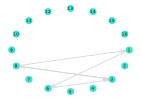

In [28]:
plot_choix_test(choix_test)

On pourrait ajouter une variable `eta_best` qui garderait en mémoire la **"meilleure version"** de la variable $\eta$ obtenu jusqu’ici (en maximisation de l’objectif). L’intérêt est que si la méthode en L ne peut pas finir (ordinateur qui plante, temps de calcul limité…), on obtient quand même une **solution réalisable**, qui est la meilleure rencontrée jusqu’à présent. Cette observation est valable parce que **le recours est complet**.

### VSS et EVPI

Pour connaître les apports de notre modèle stochastique, il est utile de regarder deux indicateurs que sont :
* la **VSS**, permettant de savoir si la solution stochastique approte quelque chose face à la solution intuitive (remplacer les données incertaines par leur moyenne)
* l'**EVPI**, permettant de savoir quel aurait été le gain si la décision de premier niveau avaiit été prise en connaissance des incertitudes

#### Calcul de la VSS

Pour calculer la VSS, il est indispensable de connaître les **valeurs moyennes** de nos données aléatoires, ici, $\xi$. Comme on sait que les composantes de $\xi$ suivent une **loi de Bernoulli**. Si on reprend les distributions présentées en début de ce document, on peut établir les **espérances**.

**Constant :** L'espérance associée à chaque arc est $1 - 0,7 = 0,3$. Elle est la même pour tous les arcs.

**NoFailure :** Même si ce cas semble irréaliste en pratique, on sait que l'espérance de chaque arc est ici 1, puisqu'il n'y a pas de possibilité d'échec. Ce cas d'étude n'est pas un problème avec recours puisque la donnée n'est pas aléatoire.

**Binomial, BinomialUNOS, BinomialEPD :** Connaissant la probabilité d'échec $f_a$ portée par l'arc, on peut en déduire la probabilité de réussite $1 - f_a$ qui n'est autre que la valeur de l'espérance pour une loi de Bernoulli.

On se propose donc de faire une fonction `esperance` qui retourne un vecteur $E(\xi)$ indicé sur les arcs $a \in A$ contenant l'espérance de chaque arc. Pour simplifier la manipulation, on ne va regarder que les arcs impliqués dans les cycles de la taille voulue, calculer l'espérance des autres arcs est inutile.

In [29]:
"""
ENTREES :
    # G : graphe avec les pairs patients/donneurs
    # L : longueur maximale des cycles
    # A : liste des arcs impliqués dans les cycles de longueur au plus L

SORTIES :
    # Exi : vecteur avec l'espérance de chaque arc
"""

function esperance(G::MetaDiGraph, L::Integer, A)
    
    lA = length(unique(A))
    Exi = zeros(lA)
    
    for a in 1:lA
        arc = unique(A)[a]
        Exi[a] = 1 - get_prop(G,Graphs.SimpleGraphs.SimpleEdge(arc[1], arc[2]),:failure)
    end
    
    return Exi
end

esperance (generic function with 1 method)

On peut ensuite définir une fonction qui va résoudre le problème de manière classique, puisqu'il n'y a plus de recours.

On sait ensuite que dans le cadre d'une maximisation $VSS =z_{SC}^* - z_{EV}^* $

In [30]:
function vss(G, L, M, sol_Lshaped, cycles, lc, Ac, A, I, Ca )

    lA = length(unique(A))
    nbc = length(cycles)
        
    xi = esperance(G, L, A)
        
    # Définition du modèle
    mod_EV = Model(GLPK.Optimizer)
        
    # Variables
    @variable(mod_EV, eta[a in 1:lA], Bin)
    @variable(mod_EV, z[c in 1:nbc], Bin )
    
    # Contraintes
    @constraint(mod_EV, max_test, sum(eta[a] for a in 1:lA) == M)    
    @constraint(mod_EV, unique_don[s in keys(I)], sum(z[c] for c in I[s]) <= 1)
    @constraint(mod_EV, test_valide[c in 1:nbc, i in [findall(x->x==a, A)[1] for a in Ac[c]]],  z[c] <= xi[i])
    @constraint(mod_EV, test_effectue[c in 1:nbc, i in [findall(x->x==a, A)[1] for a in Ac[c]]],  z[c] <= eta[i])
    
    # Objectif
    @objective(mod_EV, Max, sum(z[c]*lc[c] for c in 1:nbc))
    
    #Résolution
    set_optimizer_attribute(mod_EV, MOI.Silent(), true)
    optimize!(mod_EV)
            
    VSS = sol_Lshaped - objective_value(mod_EV) 
    
    return VSS, objective_value(mod_EV)

end

vss (generic function with 1 method)

In [31]:
vss(kep_graph, 5, 5, 4, cycles, lc, Ac, A, I, Ca)

(4.0, 0.0)

Dans ce cas ci, on voit donc qu'avoir une approche d'optimisation stochastique nous permet de sauver environ 2 personnes de plus par rappport à un problème où on utiliserait les valeurs moyennes pour $\xi$. En effet, notre fonction objectif ne fait que traduire le nombre de personne à sauver.

#### Calcul de l'EVPI

Pour calculer l'EVPI, on s'intéresse au problème *Wait-and-See* : on regarde la solution du problème si on connaissait la valeur des incertitudes. Autrement dit, ici, si l'on considère 1000 scénarios, nous allons résoudre 1000 fois le problème sans recours (avec chacune des valeurs de $\xi^k$) et calculer la moyenne de ces résultats.

Par ailleurs, on sait que $EVPI = z^* - z^*_{WS}$

In [32]:
function evpi(G, L, M, nb_sce, sol_Lshaped, cycles, lc, Ac, A, I, Ca)
    lA = length(unique(A))
    nbc = length(cycles)
    
    # Tirages des scénarios
    tirages = zeros(length(A), nb_sce) # Une colonne = un scénario
    proba = 1/nb_sce
    for sc in 1:nb_sce
        tirages[:,sc] = proba_test(G, L,cycles, lc, Ac, A, I, Ca)
    end
        
    obj_WS = zeros(nb_sce)
    
    for sc in 1:nb_sce
        
        xi = tirages[:,sc]
        
        # Définition du modèle
        mod_WS = Model(GLPK.Optimizer)
        
        # Variables
        @variable(mod_WS, eta[a in 1:lA], Bin)
        @variable(mod_WS, z[c in 1:nbc], Bin)

        # Contraintes
        @constraint(mod_WS, max_test, sum(eta[a] for a in 1:lA) == M)    
        @constraint(mod_WS, unique_don[s in keys(I)], sum(z[c] for c in I[s]) <= 1)
        @constraint(mod_WS, test_valide[c in 1:nbc, i in [findall(x->x==a, A)[1] for a in Ac[c]]],  z[c] <= xi[i])
        @constraint(mod_WS, test_effectue[c in 1:nbc, i in [findall(x->x==a, A)[1] for a in Ac[c]]],  z[c] <= eta[i])

        # Objectif
        @objective(mod_WS, Max, sum(z[c]*lc[c] for c in 1:nbc))

        #Résolution
        set_optimizer_attribute(mod_WS, MOI.Silent(), true)
        optimize!(mod_WS)
        obj_WS[sc] = objective_value(mod_WS)
    
    end
            
    EVPI =  mean(obj_WS) - sol_Lshaped 
    
    return EVPI, mean(obj_WS)

end

evpi (generic function with 1 method)

In [33]:
evpi(kep_graph, 5, 5, 1000, 4, cycles, lc, Ac, A, I, Ca )

(3.616, 0.384)

On voit donc ici qu'on aurait pu sauver un peu plus de 3 personnes si on avait su à l'avance les résultats des tests croisées.

## Robuste 

Qu'est ce qu'un pire cas ?

Les gens qui en ont le plus besoin ne sont pas sauvé,

Proba très faible dans les cycles. 




Conclusion : Dans ce modèle, on constate que beaucoup de tests croisés sont à effectuer pour choisir les "meilleurs" cycles à mettre en oeuvre. Il semblerait donc pertinent de trouver une méthode de sélection de certains cycles avant la connaissance de toutes ces probabilités pour réduire le nombre de tests croisés à effectuer.